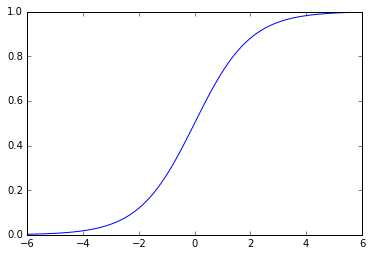

In [5]:
import numpy as np
from matplotlib import pyplot

%matplotlib inline

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

def dsigmoid(z):
  """Sigmod derivative."""
  return np.multiply(sigmoid(z), (1 - sigmoid(z)))

def plot_func(func, x):
  pyplot.plot(x, func(x))

def plot_sigmoid():
  plot_func(sigmoid, np.arange(-6, 6, 0.1))  
  
plot_sigmoid()

In [6]:
np.dot(np.array([1, 1, 1]), np.array([3, 4, 5]).T)

12

In [7]:
def get_weight_sizes(unit_sizes):
  """Returns sizes for each weight matrix according to all units."""
  layer_sizes = []
  prev_unit_size = unit_sizes[0]
  for unit_size in unit_sizes[1:]:    
    layer_sizes.append([unit_size, prev_unit_size + 1])
    prev_unit_size = unit_size
  return layer_sizes

def generate_weights(input_size, output_size, hidden_layer_size, num_hidden_layers=1):  
  """Returns array of matrices representing weights (connections between units)."""
  unit_sizes = [input_size] + num_hidden_layers * [hidden_layer_size] + [output_size]
  print "Unit sizes", unit_sizes
  weight_sizes = get_weight_sizes(unit_sizes)
  print "Weight sizes", weight_sizes
  return [2 * np.random.random(weight_size) - 1 for weight_size in weight_sizes]
 
def unroll_weights(weights):
  """Turn list of matrices to a list of all the elements in order."""
  unrolled = []
  for weight in weights:
    unrolled += np.asarray(weight).flatten().tolist()  
  return np.matrix(unrolled)

def expand_weights(theta, weight_sizes):  
  offset = 0
  weights=[]
  for rows, cols in weight_sizes:    
    length = rows * cols
    chunk = np.squeeze(np.asarray(theta)).tolist()[offset:offset+length]        
    weights.append(np.array(np.reshape(chunk, (rows, cols))))    
    offset += length
  return weights

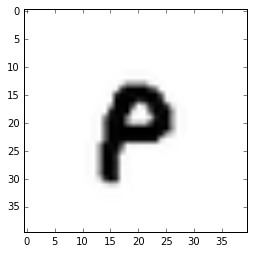

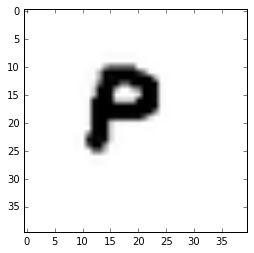

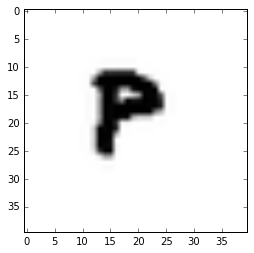

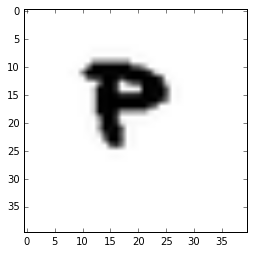

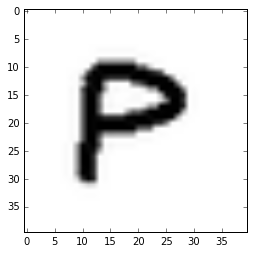

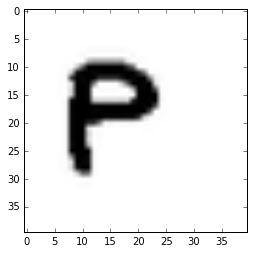

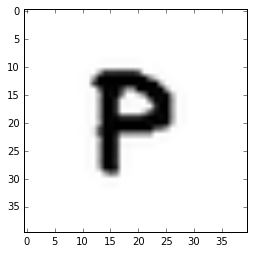

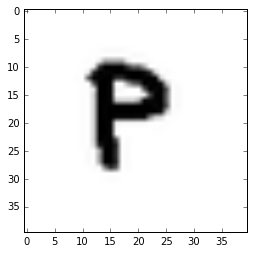

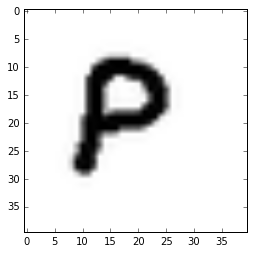

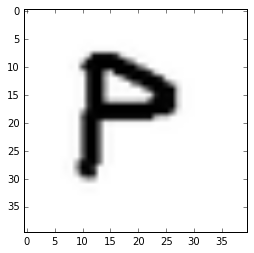

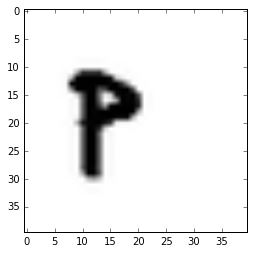

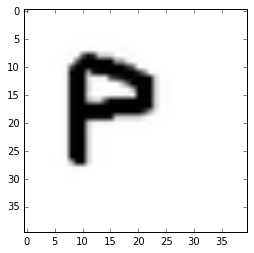

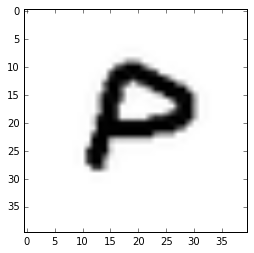

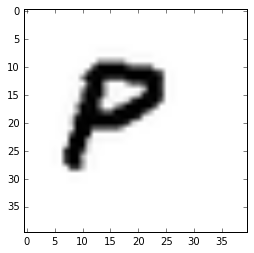

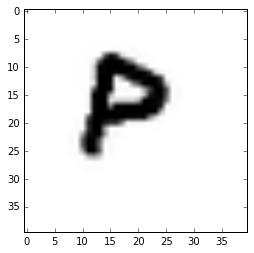

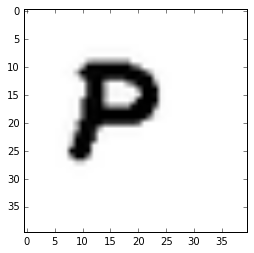

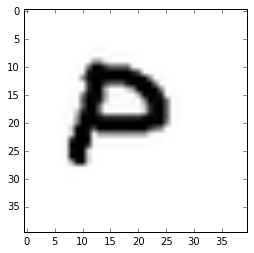

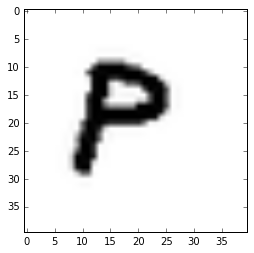

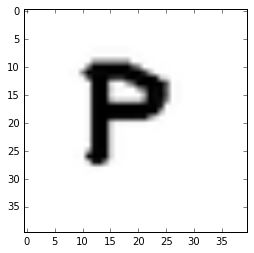

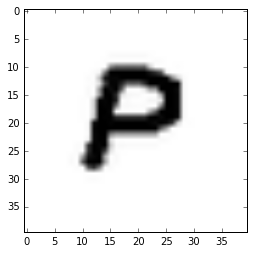

In [40]:
# Loading image
from io import BytesIO
from matplotlib import pyplot

%matplotlib inline

from PIL import Image
import os

training_data_dir = os.path.join(os.getcwd(), "handwriting", "training-data")

def image_to_intensity(im):
  im.convert('LA')
  return [1 - np.average(color)/255 for color in list(im.getdata())]

def get_handwriting_training_files(letter):
  directory = os.path.join(training_data_dir, letter)  
  for (dirpath, dirnames, filenames) in os.walk(directory):
    for filename in filenames:
      yield os.path.join(directory, filename)

def get_handwriting_training_data(letter, display=False, w=40, h=40):
   for filename in get_handwriting_training_files(letter):
      im = Image.open(filename)
      im.thumbnail((w, h), Image.ANTIALIAS)
      
      if display:
        pyplot.figure()
        pyplot.imshow(np.asarray(im))
        
      data = image_to_intensity(im)
      yield data
      
for sample in get_handwriting_training_data("p", True):  
  continue
      

# print image_to_intensity(im)





In [14]:
# y - all the input examples without the x0 = 1 column
# y - all the ouputs of the neural net
# weights - a list of matrices for each layer of neural network
def cost_function(x, y, weights, g=sigmoid, dg=dsigmoid, lamb=0):
  m = x.shape[0]
  j = 0;
  grad = 0;

  one_column = np.ones([m, 1])  
  num_hidden_layers = len(weights) - 1
  
  # input layer + hidden layers + output layer
  num_layers = num_hidden_layers + 2
    
  # number of rows in the last weight matrix is the number of output classes.
  num_classes = weights[-1:][0].shape[0]
  
  # print "Number of layers:", num_layers
  # print "Number of hidden layers:", num_hidden_layers
  # print "Number of classes", num_classes
 
  # Map the output to a class vector for the last layer : e.g. 3 --> [0, 0, 1, 0, ...]
  y_ = np.zeros((m, num_classes))  
  for i in range(0, m):
    y_[i, y[i]] = 1

  #######################
  # Forward propagation #
  #######################
  a = [None] * num_layers
  z = [None] * num_layers

  a[0] = np.c_[one_column, x]
  # print "Propagating from layer %d to %d" % (1, 2)
    
  for i in range(1, num_layers):
    # print "Propagating from layer %d to %d" % (i+1, i+2)
    z[i] = np.dot(a[i-1], weights[i-1].T)
    a[i] = np.c_[one_column, g(z[i])]
  
  # Remove the one column. This is the hypothesis applied to all data.
  h = a[num_layers-1][:, 1:]
        
  ##################
  # Regularization #
  ##################
  reg_inner_term = 0.0
  for theta in weights:
    # We skip the first column (or we could dub it zero.)
    reg_inner_term += np.sum(theta[:, 1:] ** 2)    
  reg_inner_term *= 0.5 * lamb
  
  ########
  # Cost #
  ########
  cost_0_term = np.multiply(-y_, np.log(h)) # element-wise multiplication
  cost_1_term = np.multiply((1 - y_), np.log(1 - h)) # element-wise multiplication
  cost = (np.sum(cost_0_term + cost_1_term) + reg_inner_term) / m;
  
  ##############################
  # Backpropagation & Gradient #
  ##############################
  delta = [None] * num_layers  
  weights_grad = [0.0] * (num_hidden_layers + 1)
  
  for t in range(0, m):
    delta[num_layers - 1] = (h[t] - y_[t]).T
    # Use one column when multiplying, afterwards remove the one-row.
    for j in range(num_layers-1, 1, -1):
      delta[j - 1] = np.multiply(weights[j - 1].T * delta[j], dg(np.c_[1, z[j - 1][t]].T))[1:, :]
    
    for j in range(0, num_hidden_layers+1):
      weights_grad[j] += delta[j + 1] * a[j][t]
  
  for j in range(0, num_hidden_layers + 1):
    grad_reg_term = lamb * weights[j]
    grad_reg_term[0] = 0    
    weights_grad[j] = (weights_grad[j] + grad_reg_term) / m
    
  grad = np.matrix(unroll_weights(weights_grad))
  
  return (cost, grad)


In [78]:
# alpha = learning rate
# dg - gradient of cost_function
def gradient_descent(theta, dg, alpha=0.1, precision=0.0001, iterations=1000):
  for i in range(0, iterations):
    theta -= alpha * dg    
    weights=expand_weights(theta, weight_sizes)
    cost, dg = cost_function(x,y, weights)
    precision_reached = (abs(cost) < precision)
    if i % 50 == 0 or precision_reached:
      print "Cost", cost, "Precision:", precision
      
    if precision_reached:
      return weights
    
  return weights

In [81]:
# all available letter training data
letters="kopar_tgcx"

i=0
training_data = {}
for l in letters:  
  training_data[l]=i
  i+=1

training_data_reverse = {v: k for k, v in training_data.items()}

img_width = 40
img_height = 40

# Neural network specification
input_size = img_width * img_height
output_size = len(training_data.values())
hidden_layer_size = 80
num_hidden_layers = 2

# Random initial weights for the NN.
weights = generate_weights(input_size, output_size, hidden_layer_size, num_hidden_layers)

# for debug only
unit_sizes = [input_size] + num_hidden_layers * [hidden_layer_size] + [output_size]  
weight_sizes = get_weight_sizes(unit_sizes)

input_data = []
output_data = []

# Percentage of the data set used for training (the rest goes for testing/cross-validation)
training_percentage = 0.7

example_set_size = 20
training_set_size = int(round(example_set_size * training_percentage))

print "training_set_size:", training_set_size

print "Loading letters:",

for letter, y_val in training_data.iteritems():
  print letter,
  i = 0  
  for sample in get_handwriting_training_data(letter):    
    if i < training_set_size:      
      input_data.append(sample)
      output_data.append(y_val)
    i += 1
  
x = np.matrix(input_data)
y = np.matrix(np.array(output_data)).T

print
print "Input and output sizes", (x.shape, y.shape)



Unit sizes [1600, 80, 80, 10]
Weight sizes [[80, 1601], [80, 81], [10, 81]]
training_set_size: 14
Loading letters: a c g k o p r t x _
Input and output sizes ((140L, 1600L), (140L, 1L))


In [82]:
cost, grad = cost_function(x, y, weights)
print cost, grad.shape

-15.5701042849 (1L, 135370L)


In [ ]:
# Train 
opt_weights = gradient_descent(theta=unroll_weights(weights), alpha=0.3, precision=0.0001, dg=grad)
opt_weights

In [88]:
def predict(x, weights):
  m = len(x)  
  prev_layer = sigmoid( np.matrix([1] + x) * weights[0].T);
  for j in range(1, len(weights)):    
    current_layer = sigmoid(np.matrix([1] + np.squeeze(np.asarray(prev_layer)).tolist()) * weights[j].T);
    prev_layer = current_layer
  return np.argmax(np.asarray(current_layer))

errors = 0
tests = 0
for letter, _ in training_data.iteritems():
  i = 0
  for sample in get_handwriting_training_data(letter):
    i += 1
    if i < training_set_size:
      continue
    prediction = predict(sample, opt_weights)
    predicted_letter = training_data_reverse[ prediction ]
    tests += 1
    valid = True
    if letter is not predicted_letter:
      errors += 1
      valid = False
    print "Prediction for input ", letter, " is ", predicted_letter, "" if valid else "error!"

print "accuracy %.4f%%" % ((tests - errors) * 100.0 / tests)
      


Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  x error!
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  c  is  c 
Prediction for input  c  is  c 
Prediction for input  c  is  c 
Prediction for input  c  is  c 
Prediction for input  c  is  o error!
Prediction for input  c  is  o error!
Prediction for input  c  is  _ error!
Prediction for input  g  is  g 
Prediction for input  g  is  g 
Prediction for input  g  is  g 
Prediction for input  g  is  g 
Prediction for input  g  is  g 
Prediction for input  g  is  g 
Prediction for input  g  is  r error!
Prediction for input  k  is  k 
Prediction for input  k  is  k 
Prediction for input  k  is  k 
Prediction for input  k  is  p error!
Prediction for input  k  is  p error!
Prediction for input  k  is  k 
Prediction for input  k  is  k 
Prediction for input  o  is  o 
Prediction for input  o  is  o